# Revisit Severson et al.
Peter Attia

This notebook contains most of the figures and code for our paper re-analyzing the dataset in
[Severson et al.](https://energy.stanford.edu/sites/g/files/sbiybj9971/f/346501527888d799d94279cfe74049fde53ca2d5a1275d083d28f925253cf657.pdf)

In [1]:
import os
import glob
from pathlib import Path
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

from scipy.stats import skew, kurtosis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from image_annotated_heatmap import heatmap, annotate_heatmap

## Settings

Set plotting settings:

In [2]:
fig_width = 3.25 # ECS spec is 3.25" width
fig_width_2col = 7
fig_height = (3 / 4) * fig_width # standard ratio

rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Set path for saving figures:

In [3]:
figpath = Path.cwd() / 'figs'

Define linearly spaced voltage vector (consistent with Severson):

In [4]:
Vdlin = np.linspace(3.6, 2, 1000)

Define `l1_ratios` up front to use for `ElasticNetCV` hyperparameter optimization:

In [5]:
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

## Load data
The data is stored in the `data` directory. The data was generated by the `generate_voltage_array.m` MATLAB script, which creates three folders of "voltage arrays" for the train, test1, and test2 splits in Severson et al.

We will load each dataset as 3D arrays of `[cell idx, voltage position, cycle number]`.

Note that because cycle 1 is unavailable for one batch, position 0 in axis 2 is cycle 2.
Similarly, cycle 100 is position 98 in axis 2.
In describing the cycle numbers in the text, I assume the first cycle is cycle 1 (i.e. references to cycle number in the text are one-indexed, not zero-indexed).

In [6]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob('./data/' + folder + '/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

Load three datasets (`test1` = primary test set, `test2` = secondary test set):

In [7]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

Load cycle lives:

In [8]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

Confirm 124 cells are loaded:

In [9]:
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

124
124


Define `y` values as log10 of cycle life:

In [10]:
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

Make a new version of `cycle_lives_test1` and `y_test1` that exclude the outlier battery:

In [11]:
cycle_lives_test1_mod = cycle_lives_test1.copy()
y_test1_mod = y_test1.copy()

cycle_lives_test1_mod = np.delete(cycle_lives_test1_mod, 21)
y_test1_mod = np.delete(y_test1_mod, 21)

## Voltage array illustration

This figure illustrates the voltage array (V vs. Q & cycle number) concept.

In [12]:
# Find sample cell
cellNum = 19
sample = data_train[cellNum,:,:]

# Define Qsub and Qdiv (normalized to cycle 2)
Qsub = (sample[:,:].T - sample[:,0]).T
Qdiv = (sample[:,:].T / sample[:,0]).T

# Set cell indices
idx1 = 220
idx2 = 400

Make figure:

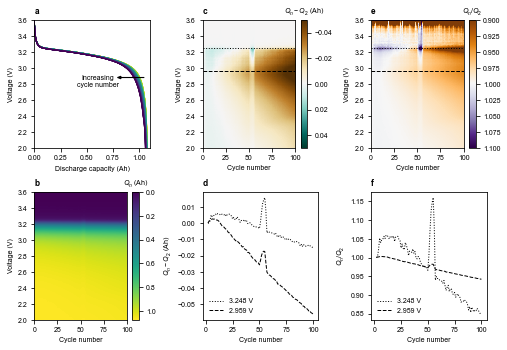

In [13]:
plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
             nrows=2, ncols=3)

colors = cm.get_cmap('viridis_r')(np.linspace(0, 1, 99))

# Panel A: Voltage curves
plt.subplot(231)
plt.title('a', loc='left', weight='bold')

for k in np.arange(99):
    plt.plot(sample[:,k], Vdlin, color=colors[k])
plt.xlabel('Discharge capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.xlim((0,1.1))
plt.ylim((2,3.6))
plt.arrow(0.95, 0.55, -0.2, 0, transform=plt.gca().transAxes, 
          zorder=3, head_width=0.02, color='k')
plt.text(0.55, 0.52, 'Increasing\ncycle number', horizontalalignment='center',
     verticalalignment='center',transform=plt.gca().transAxes)

# Panel B: Voltage matrix
plt.subplot(234)
plt.imshow(sample, extent=[0,100,3.6,2.0], aspect='auto', origin='lower')
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_title(r'$Q_n$'+' (Ah)',fontsize=7)
cbar.ax.invert_yaxis() 
plt.title('b',loc='left',weight='bold')

# Panel C: Qn - Q2
plt.subplot(232)
plt.title('c', loc='left', weight='bold')
plt.imshow(Qsub, extent=[0, 100, 3.6, 2.0], aspect='auto',
           cmap='BrBG', origin='lower', vmin=-0.05, vmax=0.05)
plt.axhline(Vdlin[idx1], color='k', ls=':')
plt.axhline(Vdlin[idx2], color='k', ls='--')
plt.gca().invert_yaxis()
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
cbar = plt.colorbar()
cbar.ax.set_title(r'$Q_n-Q_2$'+' (Ah)',fontsize=7)
cbar.ax.invert_yaxis()

# Panel D: Qn - Q2
plt.subplot(235)
plt.title('d', loc='left', weight='bold')
plt.plot(np.arange(2, 101), Qsub[idx1,:], 'k', ls=':', label=f'{Vdlin[idx1]:0.3f} V')
plt.plot(np.arange(2, 101), Qsub[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
plt.xlabel('Cycle number')
plt.ylabel(r'$Q_n-Q_2$'+' (Ah)')
plt.legend()

# Panel E: Qn / Q2
plt.subplot(233)
plt.title('e', loc='left', weight='bold')
im = plt.imshow(Qdiv, extent=[0,100,3.6,2.0], aspect='auto',
                origin='lower', vmin=0.9, vmax=1.1, cmap='PuOr')
plt.axhline(Vdlin[idx1], color='k', ls=':')
plt.axhline(Vdlin[idx2], color='k', ls='--')
plt.gca().invert_yaxis()
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
cbar = plt.colorbar(im, ax=plt.gca())
cbar.ax.set_title(r'$Q_n/Q_2$', fontsize=7)
cbar.ax.invert_yaxis()

# Panel F: Qn / Q2
plt.subplot(236)
plt.title('f', loc='left', weight='bold')
plt.plot(np.arange(2, 101), Qdiv[idx1,:], 'k', ls=':', label=f'{Vdlin[idx1]:0.3f} V')
plt.plot(np.arange(2, 101), Qdiv[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
plt.xlabel('Cycle number')
plt.ylabel(r'$Q_n/Q_2$')
plt.legend(loc='lower left')

# save
plt.tight_layout()
plt.savefig(figpath / 'fig1.eps', format='eps')

$Q_n - Q_2$ and $Q_n / Q_2$ contain similar information, but $Q_n / Q_2$ appears more sensitive to temperature fluctuations at its most sensitive point.
For now we proceed with $Q_n - Q_2$ as per Severson.

## Sampling frequency

How frequently do we need to sample the voltage matrix in the voltage dimension?

Define sampling frequencies for illustration plot. Here we use all numbers divisible by 1000:

In [14]:
def factors(n):
    # https://stackoverflow.com/questions/6800193/what-is-the-most-efficient-way-of-finding-all-the-factors-of-a-number-in-python
    return sorted(list(reduce(list.__add__,
                              ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

In [15]:
sampling_frequencies = factors(1000)[:-1] # exclude 1000
mV_frequencies = (3.6 - 2.0) / (1000 / np.array(sampling_frequencies)) * 1000 # mV

Train model on $ \log10(var(\Delta Q_{100-10}(V) ))$:

In [16]:
RMSE_train = np.zeros((len(sampling_frequencies, )))
RMSE_test1 = np.zeros((len(sampling_frequencies, )))
RMSE_test2 = np.zeros((len(sampling_frequencies, )))

for k, freq in enumerate(sampling_frequencies):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = np.log10(np.var((data_train[:, ::freq, 98] - data_train[:, ::freq, 8]), axis=1))
    X_test1 = np.log10(np.var((data_test1[:, ::freq, 98] - data_test1[:, ::freq, 8]), axis=1))
    X_test2 = np.log10(np.var((data_test2[:, ::freq, 98] - data_test2[:, ::freq, 8]), axis=1))

    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit elastic net:
    enet = LinearRegression()
    enet.fit(X_train_scaled.reshape(-1, 1), y_train)
    
    # Predict on test sets:
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
    
    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1), np.power(10, y_test1_pred)) ** 0.5
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5

Confirm models match up with Table 1 from Severson: RMSE = (103, 138, 196)

In [17]:
RMSE_train[0], RMSE_test1[0], RMSE_test2[0]

(103.57307084582936, 137.90157529515275, 195.86702751536205)

Looks good, just a very minor difference in training error (103 vs 104)

In [18]:
RMSE_train_percent_change = 100 * RMSE_train / RMSE_train[0] - 100
RMSE_test1_percent_change = 100 * RMSE_test1 / RMSE_test1[0] - 100
RMSE_test2_percent_change = 100 * RMSE_test2 / RMSE_test2[0] - 100

Make figure:

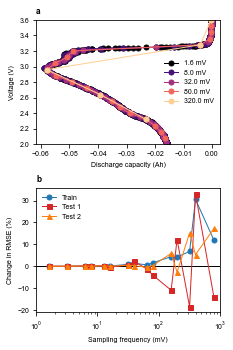

In [19]:
colors = cm.get_cmap('magma')(np.linspace(0, 0.9, 5))

fig, ax = plt.subplots(figsize=(fig_width, 2 * fig_height),
                       nrows=2, ncols=1)
ax = ax.ravel()

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

# Panel A
mV_frequencies_reduced = mV_frequencies[::3]

sample_Qsub = Qsub[:, 98] - Qsub[:, 8] # Q100 - Q10

for k, freq in enumerate(sampling_frequencies[::3]):
    
    ax[0].plot(sample_Qsub[::freq], Vdlin[::freq],
              '-o', color=colors[k], label=f'{mV_frequencies_reduced[k]} mV')

ax[0].set_ylim([2.0, 3.6])
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()

# Panel B
ax[1].semilogx(mV_frequencies, RMSE_train_percent_change, '-o', color='tab:blue', label='Train', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test1_percent_change, '-s', color='tab:red', label='Test 1', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test2_percent_change, '-^', color='tab:orange', label='Test 2', zorder=2)
ax[1].axhline(0, color='k', zorder=1)
ax[1].set_xlim([1, 1001])
ax[1].set_xlabel('Sampling frequency (mV)')
ax[1].set_ylabel('Change in RMSE (%)')
ax[1].legend()
    
# save
plt.tight_layout()
plt.savefig(figpath / 'fig2.eps', format='eps')

## Summary statistic features and transformations

Here we try various univariate models, combining different summary statistics with different transforms.

The script is set up so that these lists can be easily modified.

Define summary statistic features to extract from $ \Delta Q_{100-10}(V) $:

In [20]:
functions = {
             '$\Delta Q_{100-10}' + f'({Vdlin[220]:0.3f}$V)':    lambda x: x[:, 220],
             '$\Delta Q_{100-10}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             '$\Delta Q_{100-10}' + f'({Vdlin[-1]:0.3f}$V)':     lambda x: x[:, -1],
             'min($\Delta Q_{100-10}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{100-10}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{100-10}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{100-10}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{100-10}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{100-10}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{100-10}$)':                         lambda x: np.var(x, axis=1),
             'skew($\Delta Q_{100-10}$)':                        lambda x: skew(x, axis=1),
             'kurt($\Delta Q_{100-10}$)':                        lambda x: kurtosis(x, axis=1),
            }

Define transforms:

In [21]:
transforms = {
              'Original': lambda x: x,
              'log10':    lambda x: np.log10(np.abs(x)),
              'sqrt':     lambda x: np.sqrt(np.abs(x)),
             }

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [22]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Find Q100 - Q10:
        DeltaQ_100_minus_10_train = data_train[:, :, 98] - data_train[:, :, 8]
        DeltaQ_100_minus_10_test1 = data_test1[:, :, 98] - data_test1[:, :, 8]
        DeltaQ_100_minus_10_test2 = data_test2[:, :, 98] - data_test2[:, :, 8]
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        # For this exercise, remove outlier battery in test1 set
        X_test1 = np.delete(X_test1, 21)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit elastic net
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
        RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred)) ** 0.5
        RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.042, RMSE(train) = 263.869
log10: Skew(train) = -0.476, RMSE(train) = 240.209
sqrt: Skew(train) = 0.225, RMSE(train) = 251.197

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.190, RMSE(train) = 213.081
log10: Skew(train) = -1.470, RMSE(train) = 112.607
sqrt: Skew(train) = -0.098, RMSE(train) = 137.543

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.151, RMSE(train) = 290.926
log10: Skew(train) = -0.917, RMSE(train) = 250.589
sqrt: Skew(train) = 1.113, RMSE(train) = 255.141

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.791, RMSE(train) = 236.721
log10: Skew(train) = -0.801, RMSE(train) = 115.531
sqrt: Skew(train) = 0.441, RMSE(train) = 164.089

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.803, RMSE(train) = 236.544
log10: Skew(train) = -0.805, RMSE(train) = 113.631
sqrt: Skew(train) = 0.450, RMSE(train) = 163.217

IDR($\Delta Q_{100-10}$)
Original: Skew(train) = 1.442, RMSE(train) = 224.271
log10: Skew

Just for fun, here's a quick plot of RMSE vs `skews`:

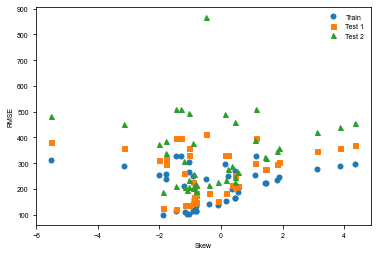

In [23]:
plt.plot(skews.ravel(), RMSE_train.ravel(), 'o', label='Train')
plt.plot(skews.ravel(), RMSE_test1.ravel(), 's', label='Test 1')
plt.plot(skews.ravel(), RMSE_test2.ravel(), '^', label='Test 2')

plt.xlabel('Skew')
plt.ylabel('RMSE')
plt.legend()

Slight correlation but not that interesting.

Plot heat map:

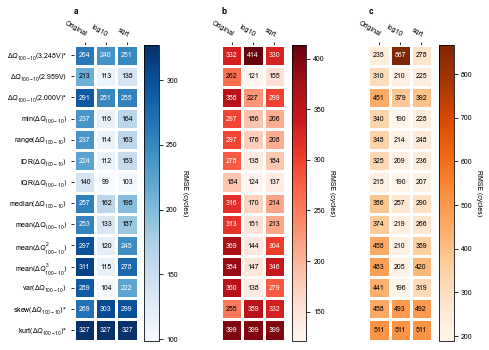

In [24]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig3.eps', format='eps')

## Linear cycle life

Repeat analysis but use linear cycle life instead of logged cycle life.

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [25]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Find Q100 - Q10:
        DeltaQ_100_minus_10_train = np.mean(data_train[:, :, 96:99], axis=2) - np.mean(data_train[:, :, 7:10], axis=2)
        DeltaQ_100_minus_10_test1 = np.mean(data_test1[:, :, 96:99], axis=2) - np.mean(data_test1[:, :, 7:10], axis=2)
        DeltaQ_100_minus_10_test2 = np.mean(data_test2[:, :, 96:99], axis=2) - np.mean(data_test2[:, :, 7:10], axis=2)
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        # For this exercise, remove outlier battery in test1 set
        X_test1 = np.delete(X_test1, 21)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit elastic net
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, cycle_lives_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(cycle_lives_train, y_train_pred) ** 0.5
        RMSE_test1[k, k2] = mean_squared_error(cycle_lives_test1_mod, y_test1_pred) ** 0.5
        RMSE_test2[k, k2] = mean_squared_error(cycle_lives_test2, y_test2_pred) ** 0.5

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.217, RMSE(train) = 274.218
log10: Skew(train) = -0.652, RMSE(train) = 238.865
sqrt: Skew(train) = 0.247, RMSE(train) = 256.741

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.163, RMSE(train) = 230.768
log10: Skew(train) = -1.479, RMSE(train) = 133.536
sqrt: Skew(train) = -0.133, RMSE(train) = 178.357

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.291, RMSE(train) = 290.829
log10: Skew(train) = -0.883, RMSE(train) = 242.210
sqrt: Skew(train) = 1.198, RMSE(train) = 261.374

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.635, RMSE(train) = 243.473
log10: Skew(train) = -1.224, RMSE(train) = 144.473
sqrt: Skew(train) = 0.207, RMSE(train) = 192.573

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.644, RMSE(train) = 243.344
log10: Skew(train) = -1.235, RMSE(train) = 143.339
sqrt: Skew(train) = 0.213, RMSE(train) = 192.060

IDR($\Delta Q_{100-10}$)
Original: Skew(train) = 1.346, RMSE(train) = 238.500
log10: Skew

Plot heat map:

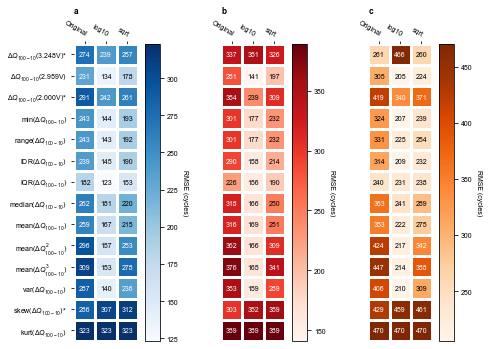

In [26]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig3_linear_cycle_life.eps', format='eps')

## Cycle number averaging (e.g. $ \Delta Q_{(98 \rightarrow 100)-(9 \rightarrow 11)}(V) $ )

For $ \Delta Q_{100-10}(V) $, we are only using two of the available 100 cycles.
This approach is "wasteful" as it doesn't consider similar neighboring cycles.
In this section, we try local averaging over multiple cycles to see if this reduces the noise and improves the predictions.

We use cycles 9, 10, and 11 for the initial cycles and 98, 99, and 100 for the final cycles (to make sure that we still use the first 100 cycles).

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [27]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Find Q100 - Q10:
        DeltaQ_100_minus_10_train = np.mean(data_train[:, :, 96:99], axis=2) - np.mean(data_train[:, :, 7:10], axis=2)
        DeltaQ_100_minus_10_test1 = np.mean(data_test1[:, :, 96:99], axis=2) - np.mean(data_test1[:, :, 7:10], axis=2)
        DeltaQ_100_minus_10_test2 = np.mean(data_test2[:, :, 96:99], axis=2) - np.mean(data_test2[:, :, 7:10], axis=2)
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        # For this exercise, remove outlier battery in test1 set
        X_test1 = np.delete(X_test1, 21)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit elastic net
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
        RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred)) ** 0.5
        RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.217, RMSE(train) = 269.383
log10: Skew(train) = -0.652, RMSE(train) = 228.576
sqrt: Skew(train) = 0.247, RMSE(train) = 250.183

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.163, RMSE(train) = 209.550
log10: Skew(train) = -1.479, RMSE(train) = 109.825
sqrt: Skew(train) = -0.133, RMSE(train) = 134.749

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.291, RMSE(train) = 291.915
log10: Skew(train) = -0.883, RMSE(train) = 252.034
sqrt: Skew(train) = 1.198, RMSE(train) = 256.713

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.635, RMSE(train) = 228.696
log10: Skew(train) = -1.224, RMSE(train) = 111.775
sqrt: Skew(train) = 0.207, RMSE(train) = 149.761

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.644, RMSE(train) = 228.433
log10: Skew(train) = -1.235, RMSE(train) = 111.278
sqrt: Skew(train) = 0.213, RMSE(train) = 148.519

IDR($\Delta Q_{100-10}$)
Original: Skew(train) = 1.346, RMSE(train) = 219.940
log10: Skew

Plot heat map:

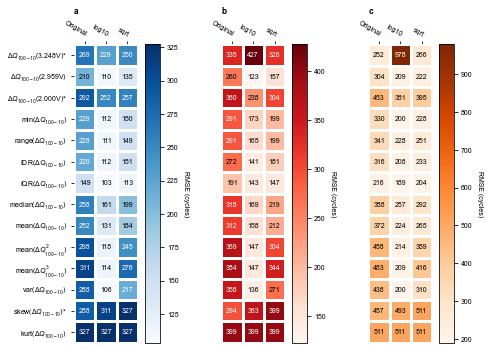

In [28]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                       nrows=1, ncols=3)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')

functions_list = list(functions.keys())
for k, func in enumerate(functions_list):
    if not do_raw_features_have_consistently_signed_values[func]: 
        functions_list[k] = func + '*'

transforms_list = list(transforms.keys())

im, cbar = heatmap(RMSE_train, row_labels=functions_list, col_labels=transforms_list, ax=ax[0],
                   cmap="Blues", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test1, col_labels=transforms_list, ax=ax[1],
                   cmap="Reds", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

im, cbar = heatmap(RMSE_test2, col_labels=transforms_list, ax=ax[2],
                   cmap="Oranges", cbarlabel="RMSE (cycles)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

plt.tight_layout()
plt.savefig(figpath / 'fig3_cycleaveraged.eps', format='eps')

## Single-point voltage prediction

Here, we evaluate the predictive capability of single elements in the voltage array.
Specifically, we evaluate the predictive ability of $ \Delta Q_{100-10}(V) $ at different values of voltage:

In [29]:
# Preinitialize
RMSE_train = np.zeros((data_train.shape[1], len(transforms)))
RMSE_test1 = np.zeros((data_test1.shape[1], len(transforms)))
RMSE_test2 = np.zeros((data_test2.shape[1], len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k in np.arange(1000):
        
    for k2, trans in enumerate(transforms):
        
        # Q_{100 - 10} at different voltages
        X_train = data_train[:, k, 98] - data_train[:, k, 8]
        X_test1 = data_test1[:, k, 98] - data_test1[:, k, 8]
        X_test2 = data_test2[:, k, 98] - data_test2[:, k, 8]
        
        # Remove outlier battery in test1 set
        X_test1 = np.delete(X_test1, 21)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        try:
            # Scale via standarization
            scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
            X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
            X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
            X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

            # Define and fit elastic net. Overkill here but whatevs
            lr = LinearRegression()
            lr.fit(X_train_scaled.reshape(-1, 1), y_train)

            # Predict on test sets
            y_train_pred = lr.predict(X_train_scaled)
            y_test1_pred = lr.predict(X_test1_scaled)
            y_test2_pred = lr.predict(X_test2_scaled)

            RMSE_train[k, k2] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
            RMSE_test1[k, k2] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred)) ** 0.5
            RMSE_test2[k, k2] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5
        
        except:
            RMSE_train[k, k2] = np.nan
            RMSE_test1[k, k2] = np.nan
            RMSE_test2[k, k2] = np.nan

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipyk

Make plot:

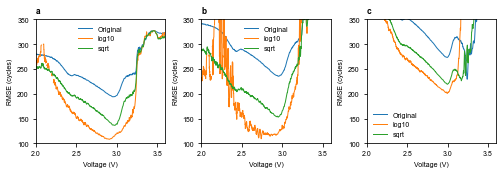

In [30]:
fig, ax = plt.subplots(figsize=(fig_width_2col, fig_height), nrows=1, ncols=3)
ax = ax.ravel()

ax[0].plot(Vdlin, RMSE_train)
ax[1].plot(Vdlin, RMSE_test1)
ax[2].plot(Vdlin, RMSE_test2)

for k in np.arange(3):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')
    ax[k].set_xlim([2, 3.6])
    ax[k].set_ylim([100, 350])
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_ylabel('RMSE (cycles)')
    ax[k].legend(transforms_list)
    
plt.tight_layout()
plt.savefig(figpath / 'fig4.eps', format='eps')

## Learning from the raw features in $ \Delta Q_{100-10}(V) $

In Severson et al. and previous sections, we used summary statistics of $ \Delta Q_{100-10}(V) $ as features for training. In this section, we consider using the raw Q-V pairs as the features instead of the summary statistics. The primary motivation is to aid interpretability by investigating the weights assigned to the various voltages, but this may also improve prediction.

### Define X matrices

Here, each feature is $ \Delta Q_{100-10}(V) $ for a range of voltages.

Note that we use every 10th voltage point in the 1000-point vector (aka 100 points total). I had trouble with elastic net convergence with the full 1000 points. The RMSE for ridge and PLS regression was insensitive to this choice.

In [31]:
# Define sampling frequency
freq = 10

# Define X matrices
X_train = data_train[:, ::freq, 98] - data_train[:, ::freq, 8]
X_test1 = data_test1[:, ::freq, 98] - data_test1[:, ::freq, 8]
X_test2 = data_test2[:, ::freq, 98] - data_test2[:, ::freq, 8]

# Remove outlier battery in test1 set
X_test1 = np.delete(X_test1, 21, axis=0)

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

### Hyperparameter optimization

For the ML methods that don't have methods for automatic hyperparamter optimization via cross-validation, we optimize the hyperparameters up front.

#### PLSR

There's only one hyperparameter here, so the optimization is easy. The below function was adapted from [this page](https://nirpyresearch.com/partial-least-squares-regression-python/).

In [32]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    """
    Run PLS including a variable number of components, up to n_comp,
    and calculate MSE
    """
    
    rmse = []
    component = np.arange(1, n_comp)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        
        # Cross-validation
        y_cv = cross_val_predict(pls, X, 10**y, cv=5)
        rmse.append(mean_squared_error(10**y, y_cv)**0.5)
    
    rmsemin = np.argmin(rmse)
    print("Suggested number of components: ", rmsemin+1)
    
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(rmse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[rmsemin], np.array(rmse)[rmsemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('RMSE')
            plt.title('PLS')
            plt.xlim(left=-1)
    
    return rmsemin + 1

Find the optimal number of PLS components:

Suggested number of components:  9


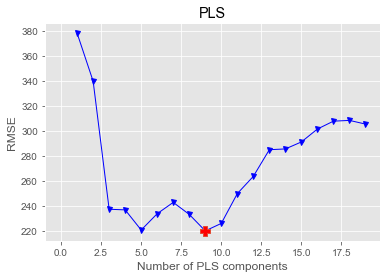

In [33]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train, 20)

#### Random forest

There are a lot of hyperparameters for the random forest algorithm, so we use a full-blown randomized search. The below code was adapted from [this page](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). These seemed like reasonable ranges of hyperparameters but of course it's possible they will miss the optimum.

In [34]:
# Defind grid of hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Define random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Define model and grid
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 0,
                               n_jobs = -1)

# Fit model
#rf_random.fit(X_train_scaled, y_train)

View results:

In [35]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

Define models to evaluate:

In [36]:
models = {
          'Ridge': RidgeCV(alphas=np.logspace(0.001, 100, 20)),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
          'PLS': PLSRegression(n_components=n_comp_plsr),
          #'Random Forest': RandomForestRegressor(**rf_random.best_params_)
         }

model_names = list(models.keys())

Evaluate error and plot:

Ridge RMSE: Train=85, Test1=125, Test2=188
Elastic net RMSE: Train=92, Test1=132, Test2=196
PLS RMSE: Train=59, Test1=100, Test2=176


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


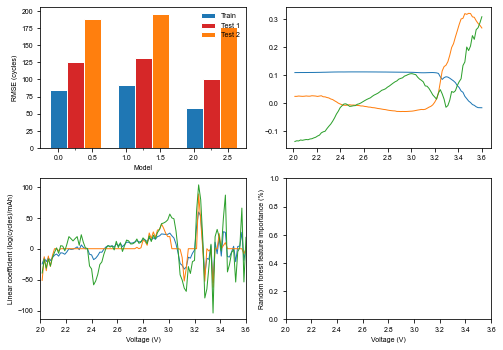

In [37]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

# set width of bar
barWidth = 0.25

fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows = 2, ncols = 2)
ax = ax.ravel()

for k, model_name in enumerate(models):
    
    # Get model object
    model = models[model_name]
    
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict on test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)

    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred)) ** 0.5
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5
    
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f}, Test1={RMSE_test1[k]:.0f}, Test2={RMSE_test2[k]:.0f}')
    
    if hasattr(model, 'x_loadings_'):
        ax[1].plot(Vdlin[::freq], model.x_loadings_[:, :3])
    if hasattr(model, 'coef_'):
        ax[2].plot(Vdlin[::freq], 1000 * model.coef_, label=model_name)
    if hasattr(model, 'feature_importances_'):
        ax[3].plot(Vdlin[::freq], 100 * model.feature_importances_)



# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plot error
ax[0].bar(r1, RMSE_train, color='tab:blue', width=barWidth, edgecolor='white', label='Train')
ax[0].bar(r2, RMSE_test1, color='tab:red', width=barWidth, edgecolor='white', label='Test 1')
ax[0].bar(r3, RMSE_test2, color='tab:orange', width=barWidth, edgecolor='white', label='Test 2')
ax[0].set_xticks([r + barWidth for r in range(len(RMSE_test2))], model_names)

ax[0].legend()

ax[2].set_xlim([2.0, 3.6])
ax[3].set_xlim([2.0, 3.6])

ax[0].set_xlabel('Model')
ax[2].set_xlabel('Voltage (V)')
ax[3].set_xlabel('Voltage (V)')

ax[0].set_ylabel('RMSE (cycles)')
ax[2].set_ylabel('Linear coefficient (log(cycles)/mAh)')
ax[3].set_ylabel('Random forest feature importance (%)')

plt.tight_layout()
plt.savefig(figpath / 'fig5.eps', format='eps')

## Cycle number averaging (e.g. $ \Delta Q_{(98 \rightarrow 100)-(9 \rightarrow 11)}(V) $ )

For $ \Delta Q_{100-10}(V) $, we are only using two of the available 100 cycles.
This approach is "wasteful" as it doesn't consider similar neighboring cycles.
In this section, we try local averaging over multiple cycles to see if this reduces the noise and improves the predictions.

We use cycles 9, 10, and 11 for the initial cycles and 98, 99, and 100 for the final cycles (to make sure that we still use the first 100 cycles).

### Define X matrices

In [38]:
# Define sampling frequency
freq = 10

# Define X matrices
X_train = np.mean(data_train[:, ::freq, 96:99], axis=2) - np.mean(data_train[:, ::freq, 7:10], axis=2)
X_test1 = np.mean(data_test1[:, ::freq, 96:99], axis=2) - np.mean(data_test1[:, ::freq, 7:10], axis=2)
X_test2 = np.mean(data_test2[:, ::freq, 96:99], axis=2) - np.mean(data_test2[:, ::freq, 7:10], axis=2)

# Remove outlier battery in test1 set
X_test1 = np.delete(X_test1, 21, axis=0)

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

### Hyperparameter optimization

For the ML methods that don't have methods for automatic hyperparamter optimization via cross-validation, we optimize the hyperparameters up front.

#### PLSR

There's only one hyperparameter here, so the optimization is easy. The below function was adapted from [this page](https://nirpyresearch.com/partial-least-squares-regression-python/).

In [39]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    """
    Run PLS including a variable number of components, up to n_comp,
    and calculate MSE
    """
    
    rmse = []
    component = np.arange(1, n_comp)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        
        # Cross-validation
        y_cv = cross_val_predict(pls, X, 10**y, cv=5)
        rmse.append(mean_squared_error(10**y, y_cv)**0.5)
    
    rmsemin = np.argmin(rmse)
    print("Suggested number of components: ", rmsemin+1)
    
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(rmse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[rmsemin], np.array(rmse)[rmsemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('RMSE')
            plt.title('PLS')
            plt.xlim(left=-1)
    
    return rmsemin + 1

Find the optimal number of PLS components:

Suggested number of components:  8


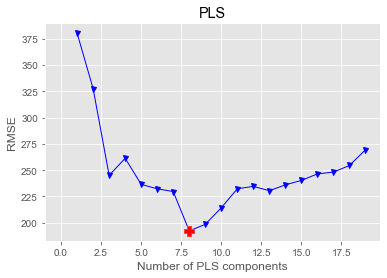

In [40]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train, 20)

#### Random forest

There are a lot of hyperparameters for the random forest algorithm, so we use a full-blown randomized search. The below code was adapted from [this page](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). These seemed like reasonable ranges of hyperparameters but of course it's possible they will miss the optimum.

In [41]:
# Defind grid of hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Define random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Define model and grid
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 0,
                               n_jobs = -1)

# Fit model
#rf_random.fit(X_train_scaled, y_train)

View results:

In [ ]:
rf_random.best_params_

Define models to evaluate:

In [42]:
models = {
          'Ridge': RidgeCV(alphas=np.logspace(0.001, 100, 20)),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
          'PLS': PLSRegression(n_components=n_comp_plsr),
          'Random Forest': RandomForestRegressor(**rf_random.best_params_
         }

model_names = list(models.keys())

SyntaxError: invalid syntax (<ipython-input-42-6892417e55e3>, line 6)

Evaluate error and plot:

In [ ]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

# set width of bar
barWidth = 0.25

fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows = 2, ncols = 2)
ax = ax.ravel()

for k, model_name in enumerate(models):
    
    # Get model object
    model = models[model_name]
    
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict on test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)

    RMSE_train[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
    RMSE_test1[k] = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred)) ** 0.5
    RMSE_test2[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5
    
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f}, Test1={RMSE_test1[k]:.0f}, Test2={RMSE_test2[k]:.0f}')
    
    if hasattr(model, 'x_loadings_'):
        ax[1].plot(Vdlin[::freq], model.x_loadings_[:, :3])        
    if hasattr(model, 'coef_'):
        ax[2].plot(Vdlin[::freq], 1000 * model.coef_)
    if hasattr(model, 'feature_importances_'):
        ax[3].plot(Vdlin[::freq], 100 * model.feature_importances_)


# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
        
# Plot error
ax[0].bar(r1, RMSE_train, color='tab:blue', width=barWidth, edgecolor='white', label='Train')
ax[0].bar(r2, RMSE_test1, color='tab:red', width=barWidth, edgecolor='white', label='Test 1')
ax[0].bar(r3, RMSE_test2, color='tab:orange', width=barWidth, edgecolor='white', label='Test 2')

ax[0].legend()
    
ax[2].set_xlim([2.0, 3.6])
ax[3].set_xlim([2.0, 3.6])

ax[0].set_xlabel('Set')
ax[2].set_xlabel('Voltage (V)')
ax[3].set_xlabel('Voltage (V)')

ax[0].set_ylabel('RMSE (cycles)')
ax[2].set_ylabel('Linear coefficient (log(cycles)/mAh)')
ax[3].set_ylabel('Random forest feature importance (%)')

plt.tight_layout()
plt.savefig(figpath / 'fig5_cycleaveraged.eps', format='eps')